In [50]:
import pandas as pd
import numpy as np
from numpy import triu
import seaborn as sns

import matplotlib.dates as mdates
import matplotlib.pyplot as plt

from wordcloud import WordCloud

from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

import textwrap
from textblob import TextBlob

import re
import nltk
from nltk.corpus import stopwords  # Importando stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer # Importando os módulos de stemming e lematização do nltk
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize  # Importando word_tokenize
# import ace_tools as tools

# Baixa os stopwords em inglês (remova se já tiver baixado anteriormente)
nltk.download('stopwords')

nltk.download('wordnet')  # WordNet para lematização
nltk.download('omw-1.4')  # WordNet data for other languages

# from scipy.linalg import triu
from gensim import corpora
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.coherencemodel import CoherenceModel 

from collections import Counter


import pyLDAvis
import pyLDAvis.gensim as gensimvis

import os
import sys
import warnings
import multiprocessing


multiprocessing.set_start_method("spawn", force=True)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/mborges/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/mborges/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/mborges/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [51]:
books_data = pd.read_csv("../project_A3DATA/csv/books_data.csv")
books_data

,Title,description,authors,image,previewLink,publisher,publishedDate,infoLink,categories,ratingsCount
0,Its Only Art If Its Well Hung!,NaN,['Julie Strain'],http://books.google.com/books/content?id=DykPA...,http://books.google.nl/books?id=DykPAAAACAAJ&d...,NaN,1996,http://books.google.nl/books?id=DykPAAAACAAJ&d...,['Comics & Graphic Novels'],NaN
1,Dr. Seuss: American Icon,Philip Nel takes a fascinating look into the k...,['Philip Nel'],http://books.google.com/books/content?id=IjvHQ...,http://books.google.nl/books?id=IjvHQsCn_pgC&p...,A&C Black,2005-01-01,http://books.google.nl/books?id=IjvHQsCn_pgC&d...,['Biography & Autobiography'],NaN
2,Wonderful Worship in Smaller Churches,This resource includes twelve principles in un...,['David R. Ray'],http://books.google.com/books/content?id=2tsDA...,http://books.google.nl/books?id=2tsDAAAACAAJ&d...,NaN,2000,http://books.google.nl/books?id=2tsDAAAACAAJ&d...,['Religion'],NaN
3,Whispers of the Wicked Saints,Julia Thomas finds her life spinning out of co...,['Veronica Haddon'],http://books.google.com/books/content?id=aRSIg...,http://books.google.nl/books?id=aRSIgJlq6JwC&d...,iUniverse,2005-02,http://books.google.nl/books?id=aRSIgJlq6JwC&d...,['Fiction'],NaN
4,"Nation Dance: Religion, Identity and Cultural ...",NaN,['Edward Long'],NaN,http://books.google.nl/books?id=399SPgAACAAJ&d...,NaN,2003-03-01,http://books.google.nl/books?id=399SPgAACAAJ&d...,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
212399,The Orphan Of Ellis Island (Time Travel Advent...,"During a school trip to Ellis Island, Dominick...",['Elvira Woodruff'],http://books.google.com/books/content?id=J7M-N...,http://books.google.com/books?id=J7M-NwAACAAJ&...,Scholastic Paperbacks,2000-06-01,http://books.google.com/books?id=J7M-NwAACAAJ&...,['Juvenile Fiction'],2.0
212400,Red Boots for Christmas,Everyone in the village of Friedensdorf is hap...,NaN,http://books.google.com/books/content?id=3n8k6...,http://books.google.com/books?id=3n8k6wl4BbYC&...,NaN,1995,http://books.google.com/books?id=3n8k6wl4BbYC&...,['Juvenile Fiction'],NaN
212401,Mamaw,"Give your Mamaw a useful, beautiful and though...",['Wild Wild Cabbage'],NaN,http://books.google.com/books?id=zytVswEACAAJ&...,NaN,2018-01-17,http://books.google.com/books?id=zytVswEACAAJ&...,NaN,NaN
212402,The Autograph Man,Alex-Li Tandem sells autographs. His business ...,['Zadie Smith'],http://books.google.com/books/content?id=JM6YV...,http://books.google.com/books?id=JM6YVPx_clMC&...,Vintage,2003-08-12,https://play.google.com/store/books/details?id...,['Fiction'],19.0


In [52]:
books_data.dtypes

Title             object
description       object
authors           object
image             object
previewLink       object
publisher         object
publishedDate     object
infoLink          object
categories        object
ratingsCount     float64
dtype: object

In [53]:
books_data.isna().sum() # resultdo da contagem de NaN em cada coluna

Title                 1
description       68442
authors           31413
image             52075
previewLink       23836
publisher         75886
publishedDate     25305
infoLink          23836
categories        41199
ratingsCount     162652
dtype: int64

In [54]:
# Removendo as colunas especificadas do dataframe
columns_to_drop = ['image', 'previewLink', 'publisher', 'infoLink']
books_data_cleaned = books_data.drop(columns=columns_to_drop)

# Exibindo as primeiras linhas do dataframe com as colunas já remividas
books_data_cleaned.head()

,Title,description,authors,publishedDate,categories,ratingsCount
0,Its Only Art If Its Well Hung!,NaN,['Julie Strain'],1996,['Comics & Graphic Novels'],NaN
1,Dr. Seuss: American Icon,Philip Nel takes a fascinating look into the k...,['Philip Nel'],2005-01-01,['Biography & Autobiography'],NaN
2,Wonderful Worship in Smaller Churches,This resource includes twelve principles in un...,['David R. Ray'],2000,['Religion'],NaN
3,Whispers of the Wicked Saints,Julia Thomas finds her life spinning out of co...,['Veronica Haddon'],2005-02,['Fiction'],NaN
4,"Nation Dance: Religion, Identity and Cultural ...",NaN,['Edward Long'],2003-03-01,NaN,NaN


In [55]:
""" para o preenchimento da colunas onde há valores valores ausentes, foi escolhido mudar por fase mais 
favoravél a coluna como é detalhado no código a baixo. 
"""

books_data_cleaned = books_data_cleaned.assign(
    Title          = books_data_cleaned['Title'].fillna('Título desconhecido'),
    description    = books_data_cleaned['description'].fillna('Informação indisponível'),
    authors        = books_data_cleaned['authors'].fillna('Autor desconhecido'),
    publishedDate  = books_data_cleaned['publishedDate'].fillna('0000-00-00'),
    categories     = books_data_cleaned['categories'].fillna('Sem categoria'),
    ratingsCount   = books_data_cleaned['ratingsCount'].fillna(0)
)

books_data_cleaned

,Title,description,authors,publishedDate,categories,ratingsCount
0,Its Only Art If Its Well Hung!,Informação indisponível,['Julie Strain'],1996,['Comics & Graphic Novels'],0.0
1,Dr. Seuss: American Icon,Philip Nel takes a fascinating look into the k...,['Philip Nel'],2005-01-01,['Biography & Autobiography'],0.0
2,Wonderful Worship in Smaller Churches,This resource includes twelve principles in un...,['David R. Ray'],2000,['Religion'],0.0
3,Whispers of the Wicked Saints,Julia Thomas finds her life spinning out of co...,['Veronica Haddon'],2005-02,['Fiction'],0.0
4,"Nation Dance: Religion, Identity and Cultural ...",Informação indisponível,['Edward Long'],2003-03-01,Sem categoria,0.0
...,...,...,...,...,...,...
212399,The Orphan Of Ellis Island (Time Travel Advent...,"During a school trip to Ellis Island, Dominick...",['Elvira Woodruff'],2000-06-01,['Juvenile Fiction'],2.0
212400,Red Boots for Christmas,Everyone in the village of Friedensdorf is hap...,Autor desconhecido,1995,['Juvenile Fiction'],0.0
212401,Mamaw,"Give your Mamaw a useful, beautiful and though...",['Wild Wild Cabbage'],2018-01-17,Sem categoria,0.0
212402,The Autograph Man,Alex-Li Tandem sells autographs. His business ...,['Zadie Smith'],2003-08-12,['Fiction'],19.0


In [56]:
books_data_cleaned.isna().sum() # resultdo da contagem de NaN em cada coluna

Title            0
description      0
authors          0
publishedDate    0
categories       0
ratingsCount     0
dtype: int64

In [57]:
books_data_cleaned.publishedDate # observa-se que as datas publishedDate não são padronizadas

0               1996
1         2005-01-01
2               2000
3            2005-02
4         2003-03-01
             ...    
212399    2000-06-01
212400          1995
212401    2018-01-17
212402    2003-08-12
212403    1998-01-01
Name: publishedDate, Length: 212404, dtype: object

In [58]:
# Padronizar a coluna publishedDate para casos onde há apenas o ano (adicionar "-01-01" para indicar o início do ano)

# Verificar se a data contém apenas o ano (4 dígitos) e aplicar o ajuste
books_data_cleaned['publishedDate'] = books_data_cleaned['publishedDate'].apply(
    lambda date: f"{date}-01-01" if re.fullmatch(r'\d{4}', str(date)) else date
)

# Verificar a coluna após a padronização
books_data_cleaned['publishedDate'].head()

0    1996-01-01
1    2005-01-01
2    2000-01-01
3       2005-02
4    2003-03-01
Name: publishedDate, dtype: object

In [59]:
books_data_cleaned

,Title,description,authors,publishedDate,categories,ratingsCount
0,Its Only Art If Its Well Hung!,Informação indisponível,['Julie Strain'],1996-01-01,['Comics & Graphic Novels'],0.0
1,Dr. Seuss: American Icon,Philip Nel takes a fascinating look into the k...,['Philip Nel'],2005-01-01,['Biography & Autobiography'],0.0
2,Wonderful Worship in Smaller Churches,This resource includes twelve principles in un...,['David R. Ray'],2000-01-01,['Religion'],0.0
3,Whispers of the Wicked Saints,Julia Thomas finds her life spinning out of co...,['Veronica Haddon'],2005-02,['Fiction'],0.0
4,"Nation Dance: Religion, Identity and Cultural ...",Informação indisponível,['Edward Long'],2003-03-01,Sem categoria,0.0
...,...,...,...,...,...,...
212399,The Orphan Of Ellis Island (Time Travel Advent...,"During a school trip to Ellis Island, Dominick...",['Elvira Woodruff'],2000-06-01,['Juvenile Fiction'],2.0
212400,Red Boots for Christmas,Everyone in the village of Friedensdorf is hap...,Autor desconhecido,1995-01-01,['Juvenile Fiction'],0.0
212401,Mamaw,"Give your Mamaw a useful, beautiful and though...",['Wild Wild Cabbage'],2018-01-17,Sem categoria,0.0
212402,The Autograph Man,Alex-Li Tandem sells autographs. His business ...,['Zadie Smith'],2003-08-12,['Fiction'],19.0


In [60]:
# Verifique a quantidade de datas únicas
# Verificar a quantidade de datas únicas na coluna publishedDate
unique_dates_count = books_data_cleaned['publishedDate'].nunique()
unique_dates_count

11491

In [61]:
# Datas publicadas mais frequentemente no conjunto de dados?
# Verificar as datas de publicação mais frequentes no conjunto de dados
most_frequent_dates = books_data_cleaned['publishedDate'].value_counts().head(10)
most_frequent_dates

publishedDate
0000-00-00    25305
2000-01-01     4718
1999-01-01     4381
2004-01-01     4304
2002-01-01     4273
2001-01-01     4209
2003-01-01     4208
1998-01-01     4084
2005-01-01     3882
1997-01-01     3596
Name: count, dtype: int64

In [62]:
# Filtrar conjunto de dados por um ano específico publicado
# Solicitar o ano para o filtro e garantir que tenha quatro dígitos
while True:
    year = input("Escolha o ano (ex: 2000): ")
    if year.isdigit() and len(year) == 4:
        break
    else:
        print("Por favor, insira um ano válido com quatro dígitos.")

# Solicitar o número de linhas para exibição e garantir que seja um número inteiro
while True:
    try:
        display = int(input("Quantas linhas de visualização?: "))
        if display > 0:
            break
        else:
            print("Por favor, insira um número inteiro positivo.")
    except ValueError:
        print("Por favor, insira um número inteiro válido.")

# Filtrar o conjunto de dados onde o ano corresponde ao ano especificado
filtered_data = books_data_cleaned[books_data_cleaned['publishedDate'].str.startswith(year)]

# Exibir as primeiras linhas para verificar o resultado
print('\n')
filtered_data.head(display)

Escolha o ano (ex: 2000):  1982
Quantas linhas de visualização?:  4


,Title,description,authors,publishedDate,categories,ratingsCount
48,"The Jaquith family in America,",Informação indisponível,"['George Oakes Jaquith', 'Georgetta Jaquith Wa...",1982-01-01,Sem categoria,0.0
388,Sentimental imperialists: The American experie...,Informação indisponível,['James Claude Thomson'],1982-01-01,['East Asia'],0.0
403,The Night the Monster Came,"After finding giant footprints in the snow, An...",['Mary Calhoun'],1982-01-01,['Bears'],0.0
679,I'M DANCING AS FAST AS I CAN,Informação indisponível,['Barbara Gordon'],1982-09,['Diazepam'],5.0


In [63]:
# Solicitar que o usuário escolha o tipo de filtro e o número de publicações a serem exibidas
while True:
    filter_choice = input("Escolha o filtro (autor, categoria, data de publicação): ").strip().lower()
    if filter_choice in ['autor', 'categoria', 'data de publicação']:
        break
    else:
        print("Escolha inválida. Por favor, escolha entre 'autor', 'categoria' ou 'data de publicação'.")

while True:
    try:
        display = int(input("Quantas entradas de visualização deseja?: "))
        if display > 0:
            break
        else:
            print("Por favor, insira um número inteiro positivo.")
    except ValueError:
        print("Por favor, insira um número inteiro válido.")

# Filtrar e exibir os resultados com base na escolha do usuário
if filter_choice == 'autor':
    filtered_data = books_data_cleaned['authors'].value_counts().head(display)
elif filter_choice == 'categoria':
    filtered_data = books_data_cleaned['categories'].value_counts().head(display)
else:  # data de publicação
    filtered_data = books_data_cleaned['publishedDate'].value_counts().head(display)

# Exibir o resultado
print('\nResultados filtrados\n:')
# print('\n',filtered_data,'\n')
filtered_data

Escolha o filtro (autor, categoria, data de publicação):  data de publicação
Quantas entradas de visualização deseja?:  4



Resultados filtrados
:


publishedDate
0000-00-00    25305
2000-01-01     4718
1999-01-01     4381
2004-01-01     4304
Name: count, dtype: int64

In [64]:
# Contar o número de publicações por autor e exibir os autores com mais publicações
top_authors = books_data_cleaned['authors'].value_counts().head(10)
top_authors

authors
Autor desconhecido                           31413
['Rose Arny']                                  236
['William Shakespeare']                        191
['Library of Congress. Copyright Office']      178
['Agatha Christie']                            142
['Erle Stanley Gardner']                       124
["Louis L'Amour"]                              123
['Charles Dickens']                             89
['Edgar Rice Burroughs']                        85
['Rudyard Kipling']                             75
Name: count, dtype: int64

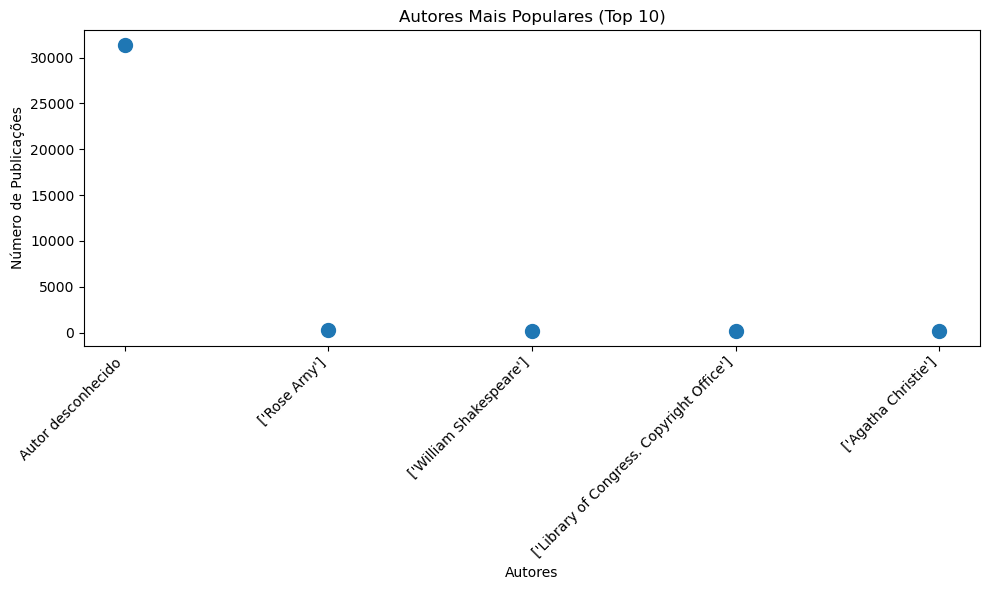

/tmp/ipykernel_7637/1944047544.py:23: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


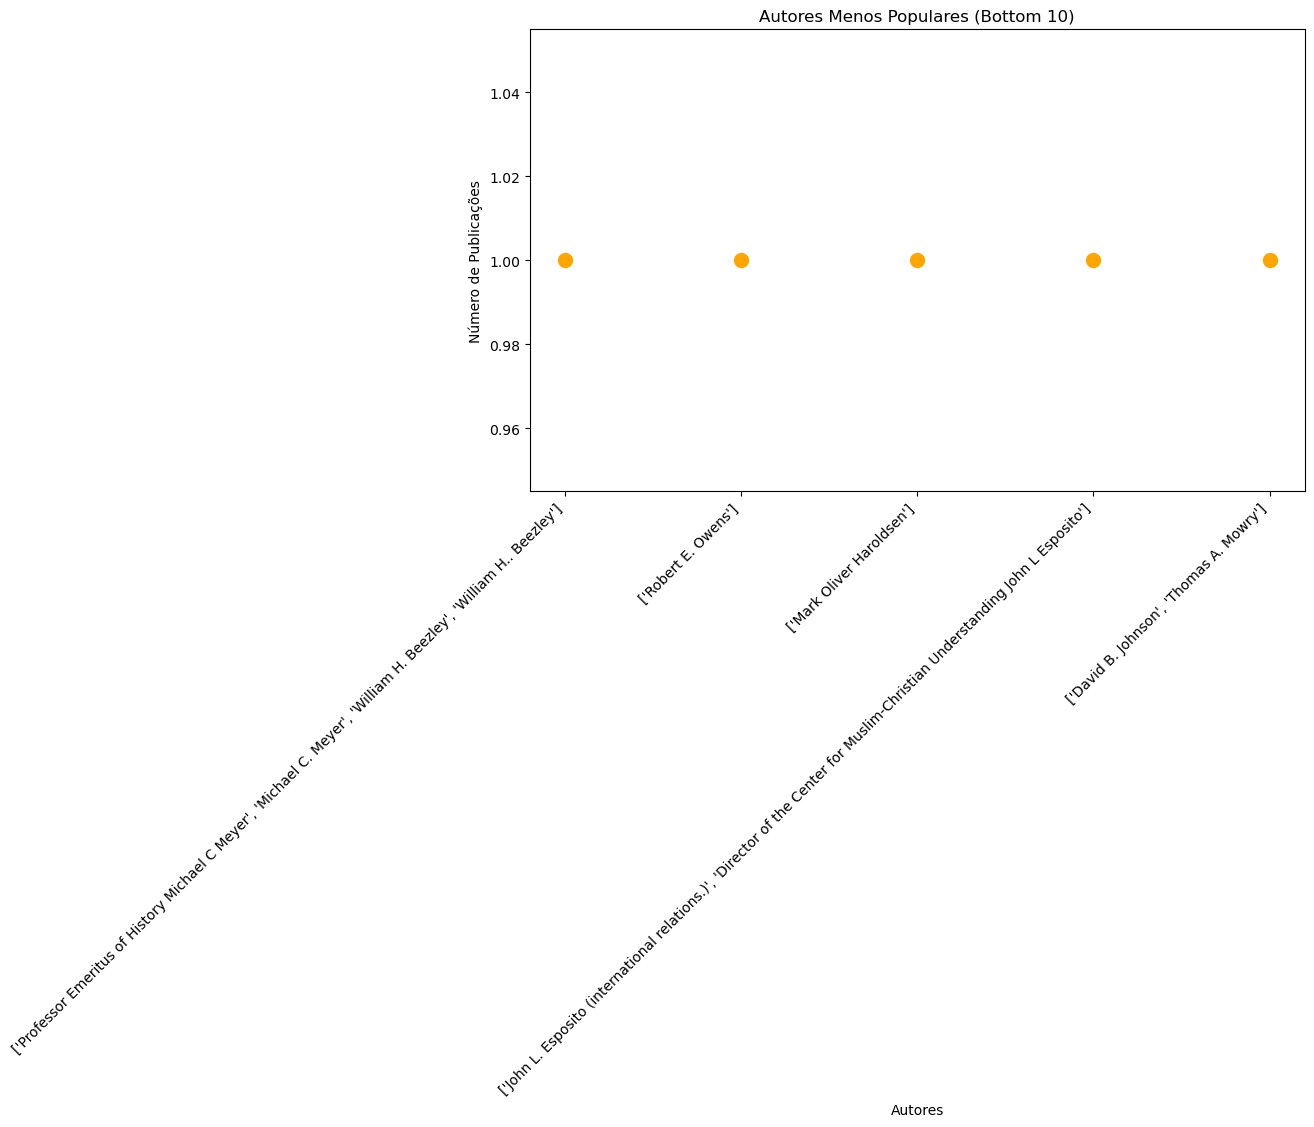

In [65]:
# Separar os autores mais populares (os 5 com mais publicações) e menos populares (os 5 com menos publicações)

top_authors = books_data_cleaned['authors'].value_counts().head(5)
least_authors = books_data_cleaned['authors'].value_counts().tail(5)

# Gráfico de dispersão para os autores mais populares
plt.figure(figsize=(10, 6))
plt.scatter(top_authors.index, top_authors.values, s=100)
plt.xticks(rotation=45, ha="right")
plt.xlabel('Autores')
plt.ylabel('Número de Publicações')
plt.title('Autores Mais Populares (Top 10)')
plt.tight_layout()
plt.show()

# Gráfico de dispersão para os autores menos populares
plt.figure(figsize=(10, 6))
plt.scatter(least_authors.index, least_authors.values, s=100, color='orange')
plt.xticks(rotation=45, ha="right")
plt.xlabel('Autores')
plt.ylabel('Número de Publicações')
plt.title('Autores Menos Populares (Bottom 10)')
plt.tight_layout()
plt.show()

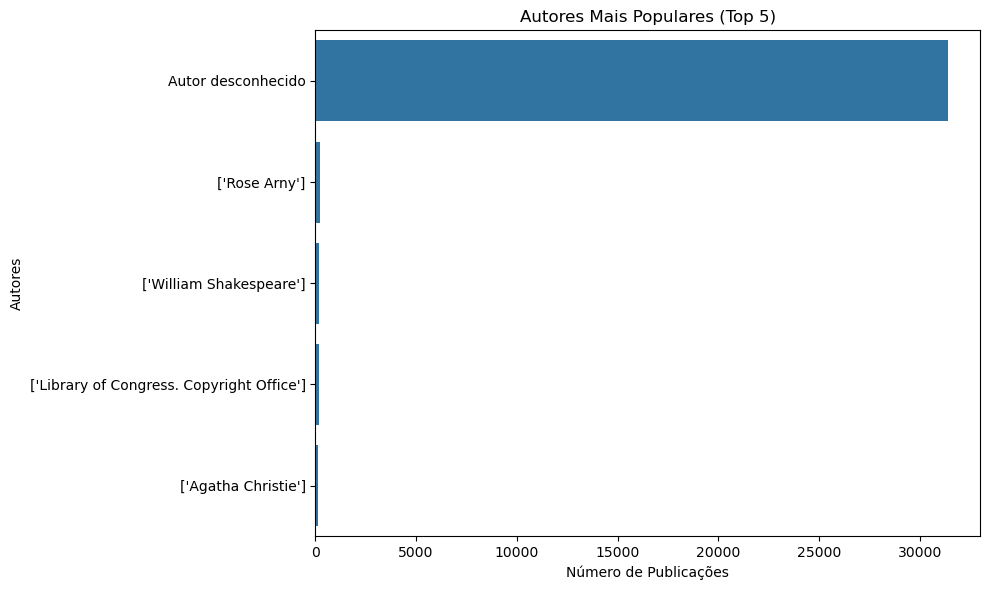

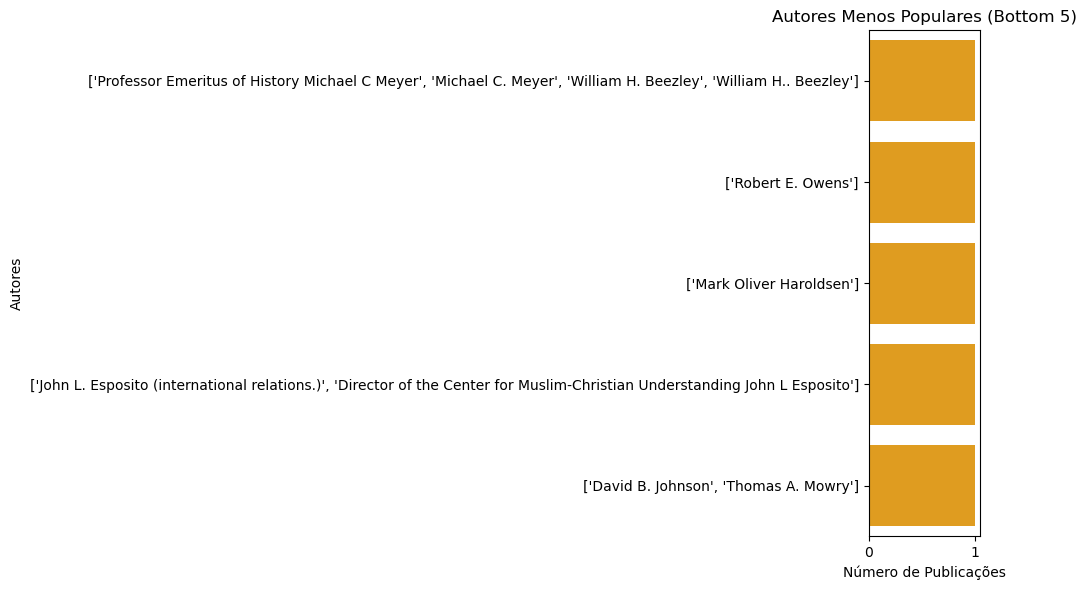

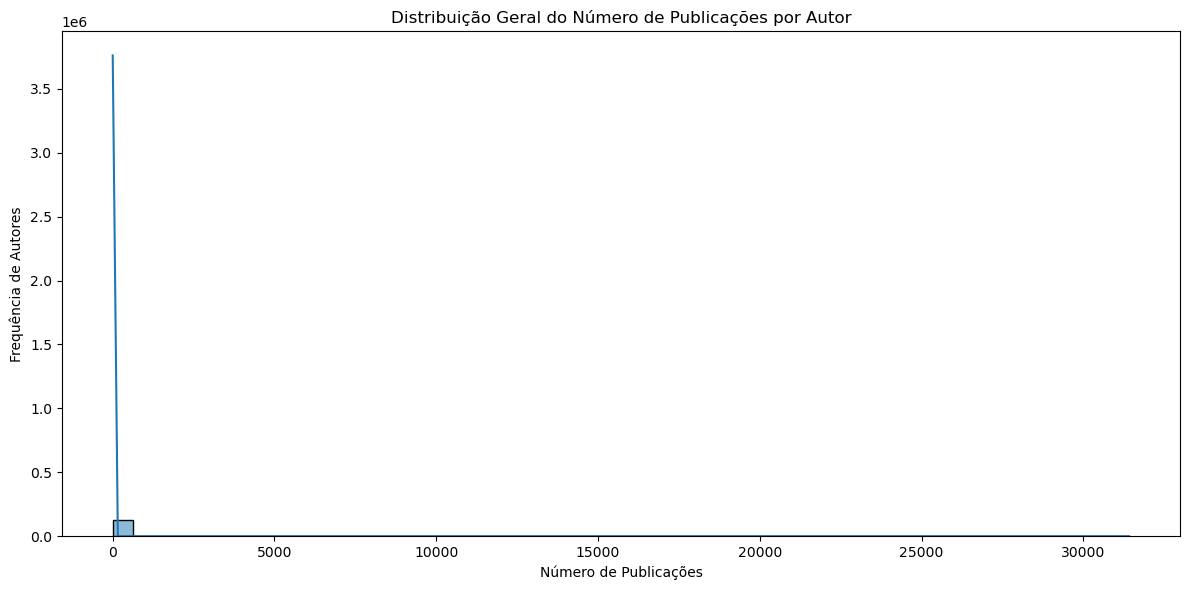

In [66]:
# Criando gráficos para demonstrar a distribuição gráfica dos insights

# Gráfico 1: Autores Mais Populares
plt.figure(figsize=(10, 6))
sns.barplot(x=top_authors.values, y=top_authors.index, orient='h')
plt.xlabel("Número de Publicações")
plt.ylabel("Autores")
plt.title("Autores Mais Populares (Top 5)")
plt.tight_layout()
plt.show()

# Gráfico 2: Autores Menos Populares
plt.figure(figsize=(10, 6))
sns.barplot(x=least_authors.values, y=least_authors.index, orient='h', color='orange')
plt.xlabel("Número de Publicações")
plt.ylabel("Autores")
plt.title("Autores Menos Populares (Bottom 5)")
plt.tight_layout()
plt.show()

# Gráfico 3: Distribuição Geral do Número de Publicações por Autor
plt.figure(figsize=(12, 6))
sns.histplot(books_data_cleaned['authors'].value_counts(), bins=50, kde=True)
plt.xlabel("Número de Publicações")
plt.ylabel("Frequência de Autores")
plt.title("Distribuição Geral do Número de Publicações por Autor")
plt.tight_layout()
plt.show()

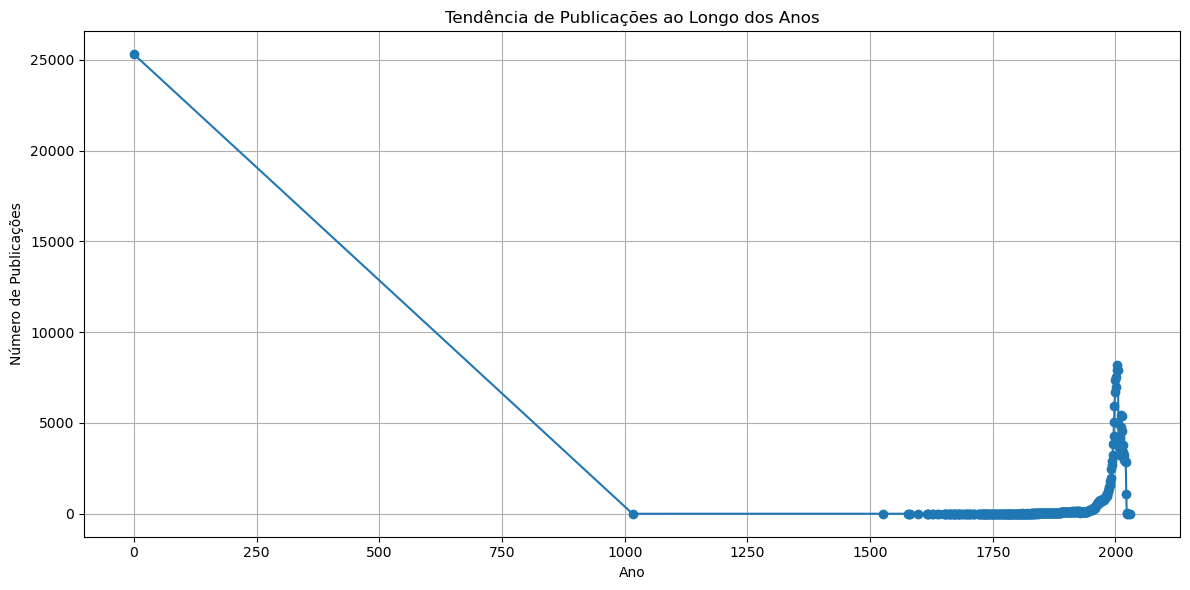

In [67]:
# Tendências de publicação de plotagem ao longo dos anos
# Extrair apenas o ano da coluna publishedDate para analisar as tendências de publicação ao longo dos anos
books_data_cleaned['year'] = books_data_cleaned['publishedDate'].str[:4]

# Converter o ano para formato numérico para ordenação e análise de tendência
books_data_cleaned['year'] = pd.to_numeric(books_data_cleaned['year'], errors='coerce')

# Contar o número de publicações por ano
publications_per_year = books_data_cleaned['year'].value_counts().sort_index()

# Plotar as tendências de publicação ao longo dos anos
plt.figure(figsize=(12, 6))
plt.plot(publications_per_year.index, publications_per_year.values, marker='o', linestyle='-')
plt.xlabel("Ano")
plt.ylabel("Número de Publicações")
plt.title("Tendência de Publicações ao Longo dos Anos")
plt.grid(True)
plt.tight_layout()
plt.show()


In [68]:
# Exibir informações gerais do dataset para análise inicial
books_data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212404 entries, 0 to 212403
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Title          212404 non-null  object 
 1   description    212404 non-null  object 
 2   authors        212404 non-null  object 
 3   publishedDate  212404 non-null  object 
 4   categories     212404 non-null  object 
 5   ratingsCount   212404 non-null  float64
 6   year           212267 non-null  float64
dtypes: float64(2), object(5)
memory usage: 11.3+ MB


In [69]:
# Criar colunas limpas a partir da coluna 'description' mantendo a original para referência
books_data_cleaned['cleaned_description'] = books_data_cleaned['description'].astype(str).apply(
    lambda x: re.sub(r'[^a-zA-Z\s]', '', x).lower()
)

# Exibir as colunas originais e a coluna limpa para verificação
books_data_cleaned[['description', 'cleaned_description']].head(8)



,description,cleaned_description
0,Informação indisponível,informao indisponvel
1,Philip Nel takes a fascinating look into the k...,philip nel takes a fascinating look into the k...
2,This resource includes twelve principles in un...,this resource includes twelve principles in un...
3,Julia Thomas finds her life spinning out of co...,julia thomas finds her life spinning out of co...
4,Informação indisponível,informao indisponvel
5,In The Church of Christ: A Biblical Ecclesiolo...,in the church of christ a biblical ecclesiolog...
6,Informação indisponível,informao indisponvel
7,Informação indisponível,informao indisponvel


In [70]:
# Baixar stopwords caso não estejam baixadas
#nltk.download('stopwords')

# Definir as stopwords em inglês
stop_words = set(stopwords.words('english'))

# Remover stopwords da coluna 'cleaned_description'
books_data_cleaned['cleaned_description_no_stopwords'] = books_data_cleaned['cleaned_description'].apply(
    lambda x: ' '.join([word for word in str(x).split() if word not in stop_words])
)

# Exibir as colunas com e sem stopwords para verificação
books_data_cleaned[['cleaned_description', 'cleaned_description_no_stopwords']].head(60)


,cleaned_description,cleaned_description_no_stopwords
0,informao indisponvel,informao indisponvel
1,philip nel takes a fascinating look into the k...,philip nel takes fascinating look key aspects ...
2,this resource includes twelve principles in un...,resource includes twelve principles understand...
3,julia thomas finds her life spinning out of co...,julia thomas finds life spinning control death...
4,informao indisponvel,informao indisponvel
5,in the church of christ a biblical ecclesiolog...,church christ biblical ecclesiology today resp...
6,informao indisponvel,informao indisponvel
7,informao indisponvel,informao indisponvel
8,the story for children and up of st hyacinth ...,story children st hyacinth dominican planted f...
9,wardell recalls his experience as a foreign st...,wardell recalls experience foreign student jap...


In [71]:
# Realizando a tokenização na coluna de texto limpo e sem stopwords
books_data_cleaned['tokenized_description'] = books_data_cleaned['cleaned_description_no_stopwords'].apply(lambda x: x.split())

# Exibindo as colunas com tokens para verificação
books_data_cleaned[['cleaned_description_no_stopwords', 'tokenized_description']].head(6)


,cleaned_description_no_stopwords,tokenized_description
0,informao indisponvel,"[informao, indisponvel]"
1,philip nel takes fascinating look key aspects ...,"[philip, nel, takes, fascinating, look, key, a..."
2,resource includes twelve principles understand...,"[resource, includes, twelve, principles, under..."
3,julia thomas finds life spinning control death...,"[julia, thomas, finds, life, spinning, control..."
4,informao indisponvel,"[informao, indisponvel]"
5,church christ biblical ecclesiology today resp...,"[church, christ, biblical, ecclesiology, today..."


In [72]:
# Inicializando o Stemmer e o Lemmatizer para inglês
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

# Aplicando stemming nos tokens de 'tokenized_description'
books_data_cleaned['stemmed_description'] = books_data_cleaned['tokenized_description'].apply(
    lambda tokens: [stemmer.stem(token) for token in tokens]
)

# Aplicando lematização nos tokens de 'tokenized_description'
books_data_cleaned['lemmatized_description'] = books_data_cleaned['tokenized_description'].apply(
    lambda tokens: [lemmatizer.lemmatize(token) for token in tokens]
)

# Exibindo as colunas com tokens lematizados e reduzidos para verificação
books_data_cleaned[['tokenized_description', 'stemmed_description', 'lemmatized_description']].head()


,tokenized_description,stemmed_description,lemmatized_description
0,"[informao, indisponvel]","[informao, indisponvel]","[informao, indisponvel]"
1,"[philip, nel, takes, fascinating, look, key, a...","[philip, nel, take, fascin, look, key, aspect,...","[philip, nel, take, fascinating, look, key, as..."
2,"[resource, includes, twelve, principles, under...","[resourc, includ, twelv, principl, understand,...","[resource, includes, twelve, principle, unders..."
3,"[julia, thomas, finds, life, spinning, control...","[julia, thoma, find, life, spin, control, deat...","[julia, thomas, find, life, spinning, control,..."
4,"[informao, indisponvel]","[informao, indisponvel]","[informao, indisponvel]"


In [73]:
# Juntando todos os tokens da coluna 'stemmed_description' para análise de frequência
all_stemmed_words = [word for tokens in books_data_cleaned['stemmed_description'] for word in tokens]

# Contando a frequência de cada palavra
word_frequency = Counter(all_stemmed_words)

# Convertendo para DataFrame para visualização
word_frequency_df = pd.DataFrame(word_frequency.items(), columns=['word', 'frequency']).sort_values(by='frequency', ascending=False)

# Exibindo o DataFrame de frequência de palavras
print("\nAnalisar frequência de palavras no texto\n")
word_frequency_df.head(10)



Analisar frequência de palavras no texto



,word,frequency
262,book,73313
0,informao,68444
1,indisponvel,68442
37,new,49028
22,one,37463
60,includ,35900
78,life,35626
170,work,33045
176,world,32643
265,use,29330


In [74]:
type(word_frequency_df)

pandas.core.frame.DataFrame

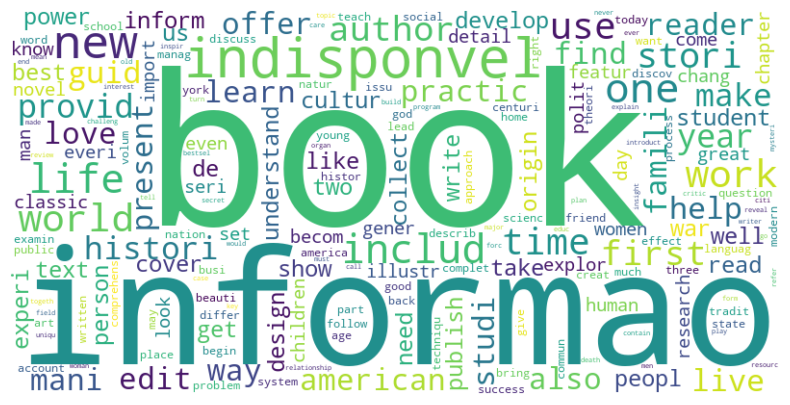

In [75]:
# Converter o DataFrame em um dicionário
word_frequency_dict = dict(zip(word_frequency_df['word'], word_frequency_df['frequency']))

# Gerando a nuvem de palavras com base nas frequências
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_frequency_dict)

# Exibindo a nuvem de palavras
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


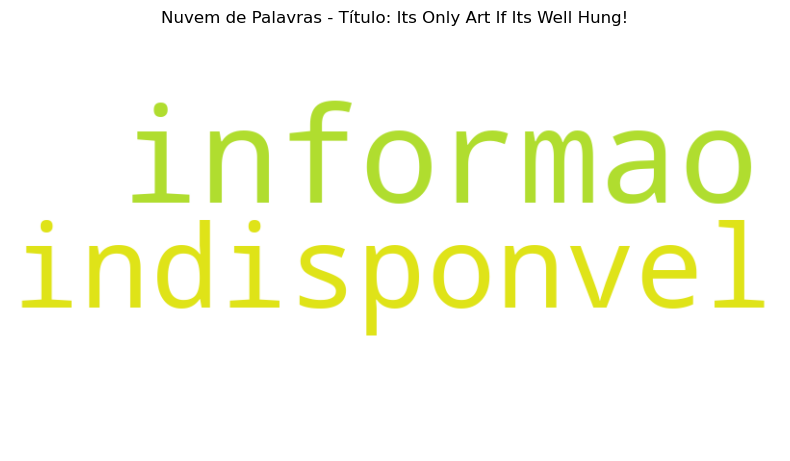

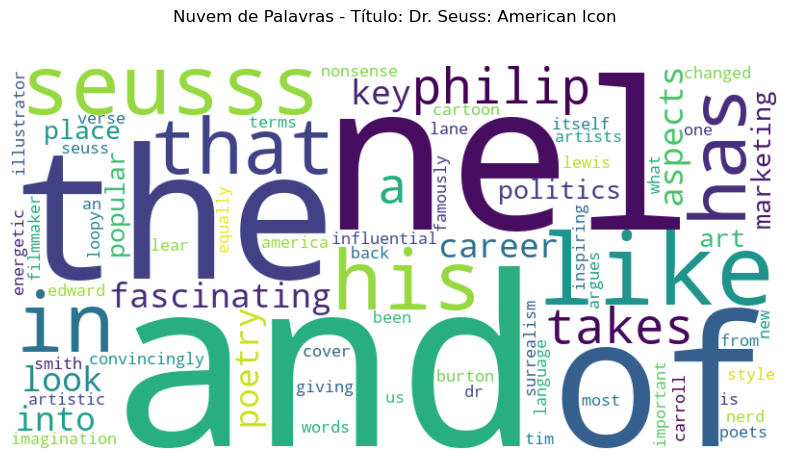

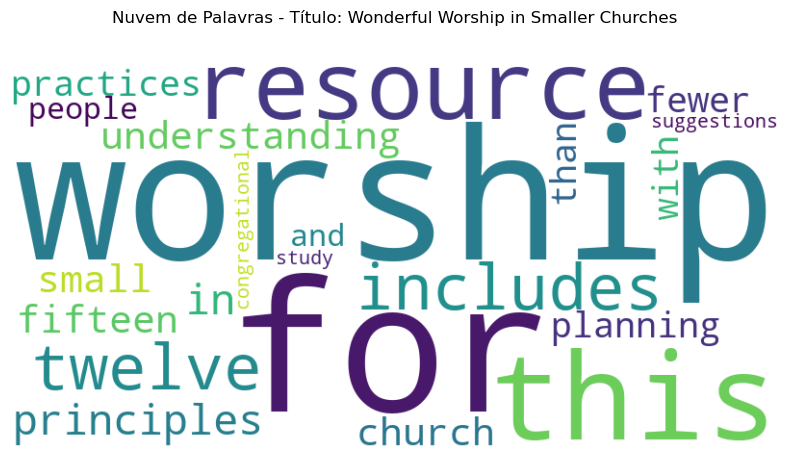

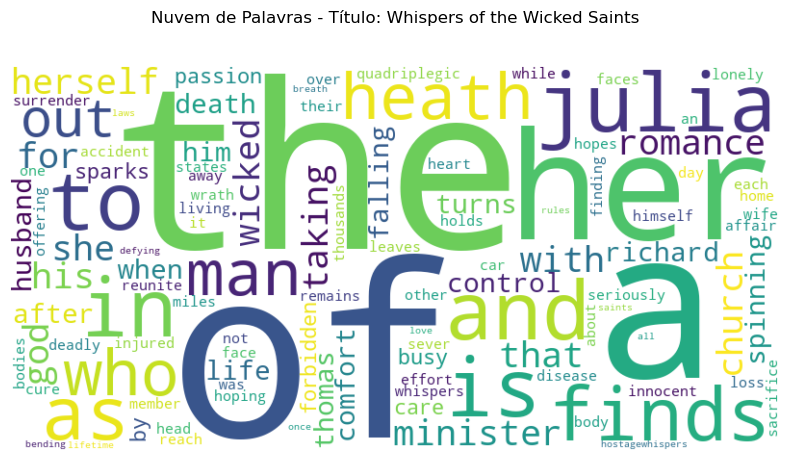

In [76]:
# Exemplo de código para criar uma nuvem de palavras por título de livro

# Selecionar alguns títulos de exemplo para visualização
example_titles = books_data_cleaned['Title'].unique()[:4]  # Selecionando apenas 4 títulos para exemplo

# Gerando e exibindo a nuvem de palavras para cada título selecionado
for title in example_titles:
    # Filtrar as palavras do texto limpo para o título específico
    words = " ".join(books_data_cleaned[books_data_cleaned['Title'] == title]['cleaned_description']).split()
    word_freq = Counter(words)
    
    # Gerando a nuvem de palavras para o título
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)
    
    # Exibindo a nuvem de palavras
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Nuvem de Palavras - Título: {title}\n\n")
    plt.show()



In [77]:
"""
Para realizar uma análise de sentimento nos resumos ou descrições dos livros, é utlizado a  biblioteca TextBlob.
A TextBlob calcula o sentimento de cada texto, retornando uma polaridade que varia de -1 (muito negativo) a +1 (muito positivo)
"""


# Aplicando a análise de sentimento diretamente nas descrições limpas e sem stopwords
books_data_cleaned['description_sentiment'] = books_data_cleaned['cleaned_description'].apply(lambda text: TextBlob(text).sentiment.polarity)

# Exibindo o DataFrame com o sentimento das descrições
print('\nExibindo o DataFrame com o sentimento das descrições\n')
books_data_cleaned[['Title', 'cleaned_description', 'description_sentiment']].head(10)



Exibindo o DataFrame com o sentimento das descrições



,Title,cleaned_description,description_sentiment
0,Its Only Art If Its Well Hung!,informao indisponvel,0.000000
1,Dr. Seuss: American Icon,philip nel takes a fascinating look into the k...,0.389141
2,Wonderful Worship in Smaller Churches,this resource includes twelve principles in un...,-0.250000
3,Whispers of the Wicked Saints,julia thomas finds her life spinning out of co...,0.048810
4,"Nation Dance: Religion, Identity and Cultural ...",informao indisponvel,0.000000
5,The Church of Christ: A Biblical Ecclesiology ...,in the church of christ a biblical ecclesiolog...,0.172727
6,The Overbury affair (Avon),informao indisponvel,0.000000
7,A Walk in the Woods: a Play in Two Acts,informao indisponvel,0.000000
8,Saint Hyacinth of Poland,the story for children and up of st hyacinth ...,0.233144
9,Rising Sons and Daughters: Life Among Japan's ...,wardell recalls his experience as a foreign st...,-0.125000


In [78]:
# Filtrar as descrições que possuem sentimento negativo
negative_descriptions_df = books_data_cleaned[books_data_cleaned['description_sentiment'] < 0][['Title', 'cleaned_description', 'description_sentiment']]

# Exibir as descrições com sentimento negativo
print("\nDescrições com Sentimento Negativo\n")
negative_descriptions_df.head(10)



Descrições com Sentimento Negativo



,Title,cleaned_description,description_sentiment
2,Wonderful Worship in Smaller Churches,this resource includes twelve principles in un...,-0.250000
9,Rising Sons and Daughters: Life Among Japan's ...,wardell recalls his experience as a foreign st...,-0.125000
15,Gold and greenstone,sally did most things better than men but it w...,-0.058333
22,Hunting The Hard Way,thrilling stories about hunting wildcat buffal...,-0.075000
29,Dealing With Disappointment: Helping Kids Cope...,why dragons so angry despite our best efforts ...,-0.063721
37,By Honor Bound (The Lassiter Law) (Silhouette ...,a comprehensive guide that defines the literat...,-0.055556
39,The New Conspiracy Reader: From Planet X to th...,this book examines a wide array of phenomena t...,-0.019424
100,"Bye-Bye, Mom and Dad",little critter thinks he is in charge when mom...,-0.187500
118,The Starchild Trilogy,the mysterious being starchild threatens to ex...,-0.100000
123,Poltergeist: The Legacy 01: The Hidden Saint,the ghostly visitation from a young boy killed...,-0.220000


In [79]:
# Criando um dicionário e uma matriz de frequência para a coluna 'stemmed_text'

# Criando um dicionário e uma matriz de frequência para a coluna 'stemmed_text'
dictionary = corpora.Dictionary(books_data_cleaned['stemmed_description'])
corpus = [dictionary.doc2bow(text) for text in books_data_cleaned['stemmed_description']]

# Treinando o modelo LDA com LdaMulticore usando 20 tópicos para mais precisão
lda_model = LdaMulticore(corpus, num_topics=10, id2word=dictionary, passes=10, random_state=42, workers=4)

# Exibindo os principais tópicos identificados
topics = lda_model.print_topics(num_words=5)
for topic in topics:
    print(topic,"\n")

# Avaliando a coerência dos tópicos
coherence_model = CoherenceModel(model=lda_model, texts=books_data_cleaned['stemmed_description'], dictionary=dictionary, coherence='c_v')
coherence_score = coherence_model.get_coherence()

print(f"\nCoerência dos Tópicos: {coherence_score}\n\n")

(0, '0.007*"one" + 0.007*"new" + 0.005*"time" + 0.005*"find" + 0.004*"get"') 

(1, '0.014*"book" + 0.013*"use" + 0.012*"includ" + 0.010*"design" + 0.009*"edit"') 

(2, '0.011*"histori" + 0.009*"american" + 0.008*"work" + 0.008*"book" + 0.008*"war"') 

(3, '0.044*"de" + 0.030*"la" + 0.020*"travel" + 0.014*"map" + 0.012*"el"') 

(4, '0.014*"life" + 0.010*"love" + 0.010*"stori" + 0.008*"live" + 0.008*"one"') 

(5, '0.009*"book" + 0.009*"food" + 0.009*"includ" + 0.008*"color" + 0.008*"recip"') 

(6, '0.045*"de" + 0.032*"van" + 0.026*"en" + 0.023*"een" + 0.019*"het"') 

(7, '0.010*"book" + 0.007*"studi" + 0.007*"new" + 0.006*"provid" + 0.006*"research"') 

(8, '0.425*"informao" + 0.424*"indisponvel" + 0.001*"und" + 0.001*"og" + 0.001*"williamson"') 

(9, '0.020*"book" + 0.014*"help" + 0.014*"learn" + 0.010*"children" + 0.010*"guid"') 


Coerência dos Tópicos: 0.590914021830949




In [80]:
# Visualização com pyLDAvis
lda_display = gensimvis.prepare(lda_model, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

/home/mborges/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=7637) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
/home/mborges/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=7637) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
/home/mborges/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=7637) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
/home/mborges/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=7637) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
/home/mborges/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/b

In [81]:
# Extraindo os tópicos para cada documento (livro) no corpus
doc_topics = [lda_model.get_document_topics(bow) for bow in corpus]

# Criando uma lista com o tópico mais relevante (de maior peso) para cada livro
book_topics = []
for doc_topic in doc_topics:
    # Ordena os tópicos do documento pela relevância e pega o tópico mais relevante
    dominant_topic = sorted(doc_topic, key=lambda x: -x[1])[0][0]
    book_topics.append(dominant_topic)

# Adicionando os tópicos dominantes aos dados
books_data_cleaned['Dominant_Topic'] = book_topics

# Exibindo os títulos e seus tópicos dominantes
books_data_cleaned[['Title', 'Dominant_Topic']].head(5)


,Title,Dominant_Topic
0,Its Only Art If Its Well Hung!,8
1,Dr. Seuss: American Icon,2
2,Wonderful Worship in Smaller Churches,7
3,Whispers of the Wicked Saints,4
4,"Nation Dance: Religion, Identity and Cultural ...",8


<Figure size 1400x1000 with 0 Axes>

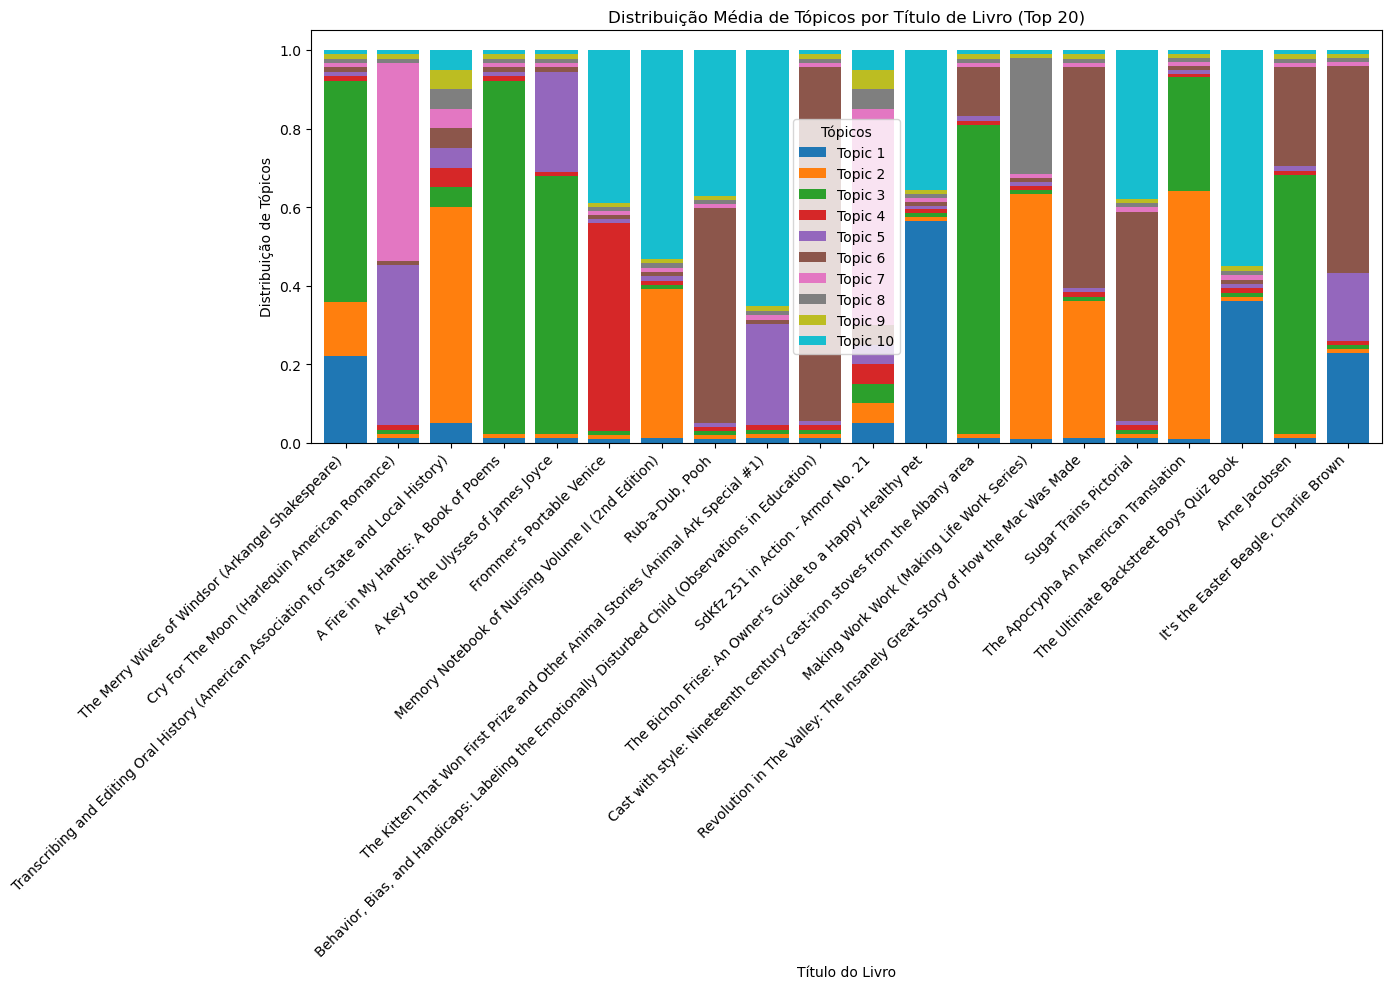

In [82]:
# Obter a distribuição de tópicos para cada documento no corpus
topic_distributions = [lda_model.get_document_topics(bow) for bow in corpus]

# Converter as distribuições de tópicos em um DataFrame para facilitar a visualização
topic_dist_df = pd.DataFrame([[topic[1] for topic in doc] for doc in topic_distributions])
topic_dist_df.columns = [f'Topic {i+1}' for i in range(topic_dist_df.shape[1])]
topic_dist_df['Title'] = books_data_cleaned['Title']

# Calculando a média dos tópicos por livro
average_topic_dist = topic_dist_df.groupby('Title').mean()

# Selecionando os 20 títulos com maior distribuição de tópicos para visualização
top_titles = average_topic_dist.sum(axis=1).nlargest(20).index
average_topic_dist_top = average_topic_dist.loc[top_titles]

# Visualizando a distribuição média dos tópicos por título de livro
plt.figure(figsize=(14, 10))
average_topic_dist_top.plot(kind='bar', stacked=True, figsize=(14, 10), width=0.8)
plt.title("Distribuição Média de Tópicos por Título de Livro (Top 20)")
plt.xlabel("Título do Livro")
plt.ylabel("Distribuição de Tópicos")
plt.legend(title="Tópicos")
plt.xticks(rotation=45, ha="right")  # Rotação nos rótulos do eixo X
plt.tight_layout()
plt.show()



Sentimento Médio por Tópico

Dominant_Topic
0    0.100429
1    0.167661
2    0.142835
3    0.147268
4    0.141411
5    0.229378
6    0.109132
7    0.125055
8    0.000035
9    0.186518
Name: description_sentiment, dtype: float64

Analisar tópicos com pontuações de sentimento



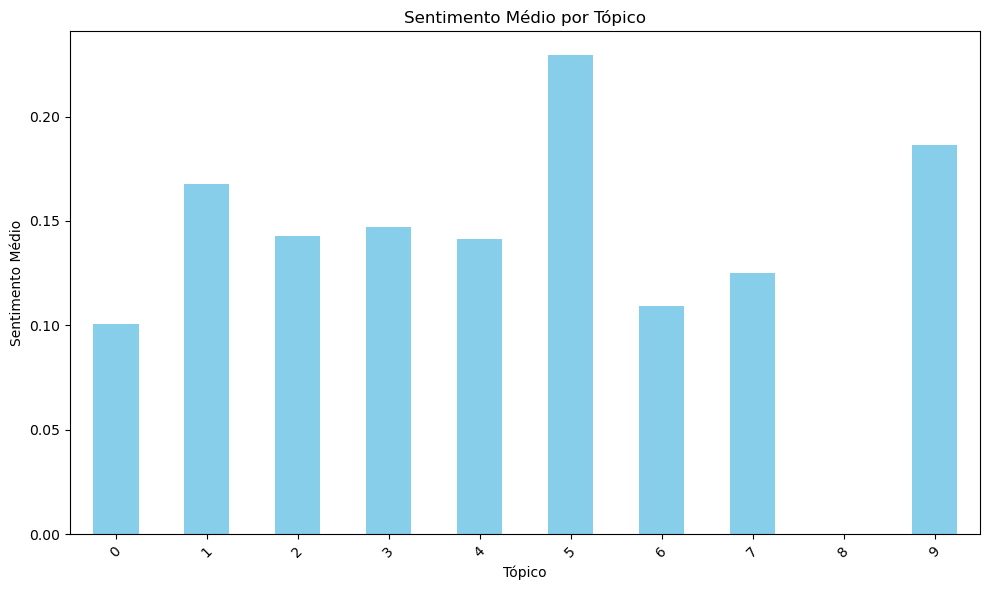

In [83]:
# Analisar tópicos com pontuações de sentimento

# Aplicar a análise de sentimento na coluna de descrições limpas
books_data_cleaned['description_sentiment'] = books_data_cleaned['cleaned_description'].apply(lambda text: TextBlob(text).sentiment.polarity)

# Extrair o tópico dominante para cada documento no corpus
doc_topics = [lda_model.get_document_topics(bow) for bow in corpus]
book_topics = [sorted(doc, key=lambda x: -x[1])[0][0] for doc in doc_topics]

# Adicionar o tópico dominante e a pontuação de sentimento ao DataFrame
books_data_cleaned['Dominant_Topic'] = book_topics

# Agrupar por tópico dominante e calcular a média de sentimento para cada tópico
topic_sentiment = books_data_cleaned.groupby('Dominant_Topic')['description_sentiment'].mean()

# Exibir o sentimento médio por tópico
print("\nSentimento Médio por Tópico\n")
print(topic_sentiment)

# Visualizar o sentimento médio por tópico com um gráfico de barras

print('\nAnalisar tópicos com pontuações de sentimento\n')

plt.figure(figsize=(10, 6))
topic_sentiment.plot(kind='bar', color='skyblue')
plt.title("Sentimento Médio por Tópico")
plt.xlabel("Tópico")
plt.ylabel("Sentimento Médio")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



Identifique tópicos com sentimento extremo


Tópicos com Sentimento Mais Positivo:

Dominant_Topic
5    0.229528
9    0.186490
1    0.167624
Name: description_sentiment, dtype: float64

Tópicos com Sentimento Mais Negativo:

Dominant_Topic
8    0.000035
0    0.100472
6    0.109210
Name: description_sentiment, dtype: float64


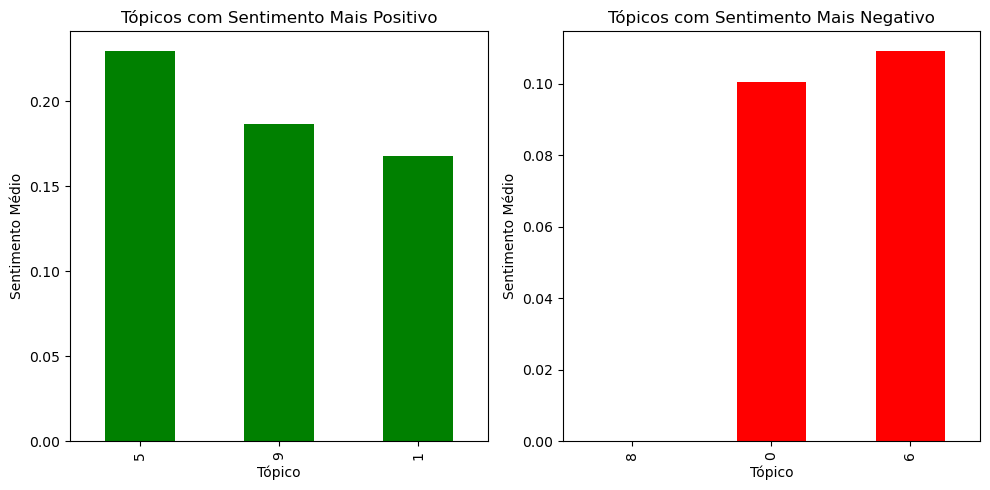

In [84]:
# Identifique tópicos com sentimento extremo

# Aplicar a análise de sentimento na coluna de descrições limpas
books_data_cleaned['description_sentiment'] = books_data_cleaned['cleaned_description'].apply(lambda text: TextBlob(text).sentiment.polarity)

# Extrair o tópico dominante para cada documento no corpus
doc_topics = [lda_model.get_document_topics(bow) for bow in corpus]
book_topics = [sorted(doc, key=lambda x: -x[1])[0][0] for doc in doc_topics]

# Adicionar o tópico dominante e a pontuação de sentimento ao DataFrame
books_data_cleaned['Dominant_Topic'] = book_topics

# Agrupar por tópico dominante e calcular a média de sentimento para cada tópico
topic_sentiment = books_data_cleaned.groupby('Dominant_Topic')['description_sentiment'].mean()

# Identificar os tópicos com sentimentos mais extremos (mais positivo e mais negativo)
most_positive_topics = topic_sentiment.nlargest(3)  # Os 3 tópicos com maior sentimento positivo
most_negative_topics = topic_sentiment.nsmallest(3)  # Os 3 tópicos com maior sentimento negativo
print("\nIdentifique tópicos com sentimento extremo\n")
print("\nTópicos com Sentimento Mais Positivo:\n")
print(most_positive_topics)

print("\nTópicos com Sentimento Mais Negativo:\n")
print(most_negative_topics)

# Visualizar os tópicos com sentimentos mais extremos
plt.figure(figsize=(10, 5))

# Gráfico para os tópicos com sentimentos mais positivos
plt.subplot(1, 2, 1)
most_positive_topics.plot(kind='bar', color='green')
plt.title("Tópicos com Sentimento Mais Positivo")
plt.xlabel("Tópico")
plt.ylabel("Sentimento Médio")

# Gráfico para os tópicos com sentimentos mais negativos
plt.subplot(1, 2, 2)
most_negative_topics.plot(kind='bar', color='red')
plt.title("Tópicos com Sentimento Mais Negativo")
plt.xlabel("Tópico")
plt.ylabel("Sentimento Médio")

plt.tight_layout()
plt.show()


In [85]:
# Texto explicativo sobre a análise
texto = """Aqui estão os primeiros resultados dos livros agrupados por similaridade, com cada título associado a um cluster específico (de 0 a 4).
        Esse agrupamento indica quais livros possuem conteúdo semelhante, conforme analisado pelo modelo K-Means usando TF-IDF."""
texto_ajustado = textwrap.fill(texto, width=60)

# Convertendo a coluna 'cleaned_description' para uma lista de strings
documents = books_data_cleaned['cleaned_description'].tolist()

# Aplicando o TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=1000)
tfidf_matrix = tfidf_vectorizer.fit_transform(documents)

# Definindo o número de clusters e aplicando o KMeans
num_clusters = 5  # Ajuste conforme necessário
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
books_data_cleaned['Cluster'] = kmeans.fit_predict(tfidf_matrix)

# Exibindo os títulos dos livros com os clusters atribuídos
df_clustered = books_data_cleaned[['Title', 'Cluster', 'cleaned_description']]

# Exibindo o texto ajustado e a tabela com os clusters atribuídos
print(texto_ajustado, "\n")
df_clustered.head(20)


Aqui estão os primeiros resultados dos livros agrupados por
similaridade, com cada título associado a um cluster
específico (de 0 a 4).         Esse agrupamento indica quais
livros possuem conteúdo semelhante, conforme analisado pelo
modelo K-Means usando TF-IDF. 



,Title,Cluster,cleaned_description
0,Its Only Art If Its Well Hung!,2,informao indisponvel
1,Dr. Seuss: American Icon,3,philip nel takes a fascinating look into the k...
2,Wonderful Worship in Smaller Churches,3,this resource includes twelve principles in un...
3,Whispers of the Wicked Saints,1,julia thomas finds her life spinning out of co...
4,"Nation Dance: Religion, Identity and Cultural ...",2,informao indisponvel
5,The Church of Christ: A Biblical Ecclesiology ...,0,in the church of christ a biblical ecclesiolog...
6,The Overbury affair (Avon),2,informao indisponvel
7,A Walk in the Woods: a Play in Two Acts,2,informao indisponvel
8,Saint Hyacinth of Poland,0,the story for children and up of st hyacinth ...
9,Rising Sons and Daughters: Life Among Japan's ...,3,wardell recalls his experience as a foreign st...


In [86]:
# Obtenção dos termos principais para cada cluster com base nos centróides do K-Means
terms = tfidf_vectorizer.get_feature_names_out()  # Extrai os termos do TF-IDF
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]  # Ordena os índices dos termos por peso

# Coletando os principais termos para cada cluster
top_terms_per_cluster = {}
for i in range(num_clusters):
    top_terms = [terms[ind] for ind in order_centroids[i, :15]]  # Pega os 15 termos mais representativos
    top_terms_per_cluster[f'Cluster {i}'] = top_terms

# Convertendo para DataFrame para melhor visualização
top_terms_df = pd.DataFrame.from_dict(top_terms_per_cluster, orient='index', columns=[f'Term {i+1}' for i in range(15)])

# Exibindo a tabela com os termos principais de cada cluster
top_terms_df

,Term 1,Term 2,Term 3,Term 4,Term 5,Term 6,Term 7,Term 8,Term 9,Term 10,Term 11,Term 12,Term 13,Term 14,Term 15
Cluster 0,the,of,and,in,to,is,his,as,that,this,with,for,on,by,from
Cluster 1,her,the,she,to,and,of,in,is,with,but,for,that,when,his,as
Cluster 2,indisponvel,informao,force,friends,friend,fresh,french,freedom,free,four,found,forms,former,format,form
Cluster 3,and,the,of,to,in,for,on,with,his,by,an,this,is,from,as
Cluster 4,and,the,to,of,you,in,for,your,is,with,this,that,how,book,on


In [87]:
# Amostrar um subconjunto dos dados (por exemplo, 10.000 livros)
subset_books = books_data_cleaned.sample(n=10000, random_state=42).reset_index(drop=True)

# Preparar e treinar o modelo Doc2Vec no subconjunto
documents = [TaggedDocument(words=text.split(), tags=[str(i)]) for i, text in enumerate(subset_books['cleaned_description'])]
doc2vec_model = Doc2Vec(documents, vector_size=50, window=2, min_count=1, epochs=40, seed=42)
book_embeddings = np.array([doc2vec_model.dv[str(i)] for i in range(len(subset_books))])

# Calcular a similaridade de cosseno e exibir a matriz para o subconjunto
similarity_matrix = cosine_similarity(book_embeddings)
similarity_df = pd.DataFrame(similarity_matrix, index=subset_books['Title'], columns=subset_books['Title'])
similarity_df.iloc[:10, :10]



Title,The Evolution of Physics: The Growth of Ideas from Early Concepts to Relativity and Quanta,Love is Now,"Lustful Turk, The",Rebel Waltz,Mobil 99: America's Best Hotels & Restaurants (Mobil Travel Guide: America's Best Restaurants and Hotels),Reversing Multiple Sclerosis: 9 Effective Steps to Recover Your Health,Stages of Meditation,Christianity: Two Thousand Years,Allied military currency;: [issues of military payment certificates from World War II--to date and emergency issues caused by a war,Operation in Search of Love
Title,,,,,,,,,,
The Evolution of Physics: The Growth of Ideas from Early Concepts to Relativity and Quanta,1.000000,0.333586,0.571213,0.548819,0.528315,0.379830,0.397891,0.412265,0.527940,0.656491
Love is Now,0.333586,1.000000,0.260289,0.395722,0.283960,0.232893,0.376486,0.294792,0.223963,0.251708
"Lustful Turk, The",0.571213,0.260289,1.000000,0.407982,0.470026,0.312623,-0.002198,-0.093038,0.873603,0.937434
Rebel Waltz,0.548819,0.395722,0.407982,1.000000,0.506419,0.206675,0.263236,0.319321,0.327396,0.426339
Mobil 99: America's Best Hotels & Restaurants (Mobil Travel Guide: America's Best Restaurants and Hotels),0.528315,0.283960,0.470026,0.506419,1.000000,0.079115,0.122631,0.157757,0.344176,0.470940
Reversing Multiple Sclerosis: 9 Effective Steps to Recover Your Health,0.379830,0.232893,0.312623,0.206675,0.079115,1.000000,0.149208,-0.032868,0.229144,0.278278
Stages of Meditation,0.397891,0.376486,-0.002198,0.263236,0.122631,0.149208,1.000000,0.393964,0.019701,0.089827
Christianity: Two Thousand Years,0.412265,0.294792,-0.093038,0.319321,0.157757,-0.032868,0.393964,1.000000,-0.161582,0.014748
Allied military currency;: [issues of military payment certificates from World War II--to date and emergency issues caused by a war,0.527940,0.223963,0.873603,0.327396,0.344176,0.229144,0.019701,-0.161582,1.000000,0.898104


/tmp/ipykernel_7637/3426863173.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=topic_counts.index, y=topic_counts.values, palette="viridis")


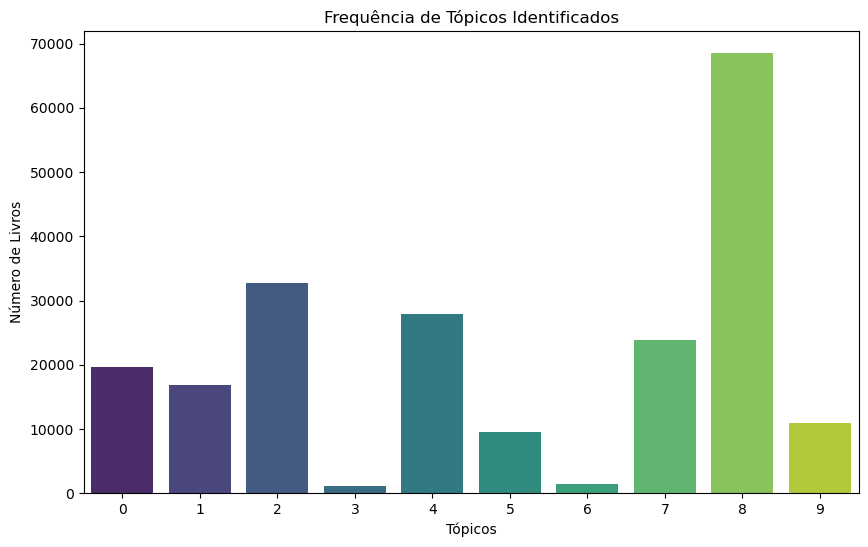

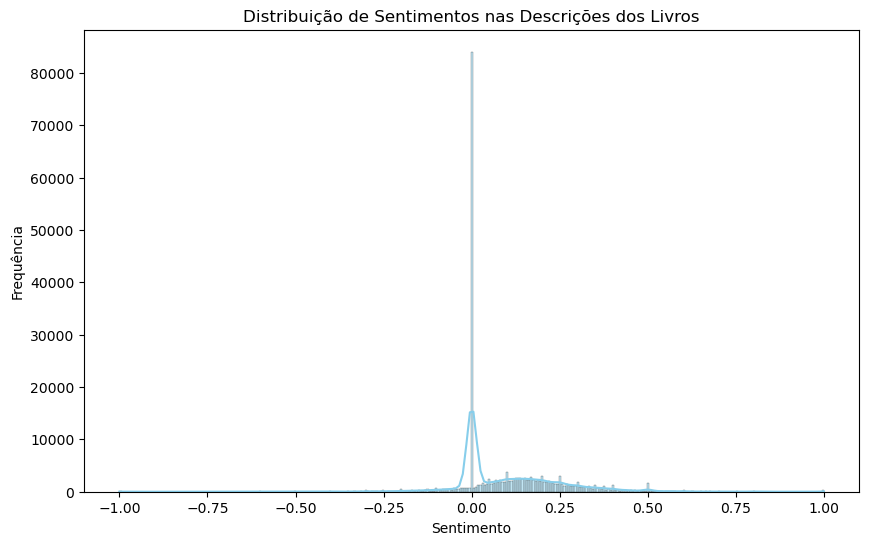

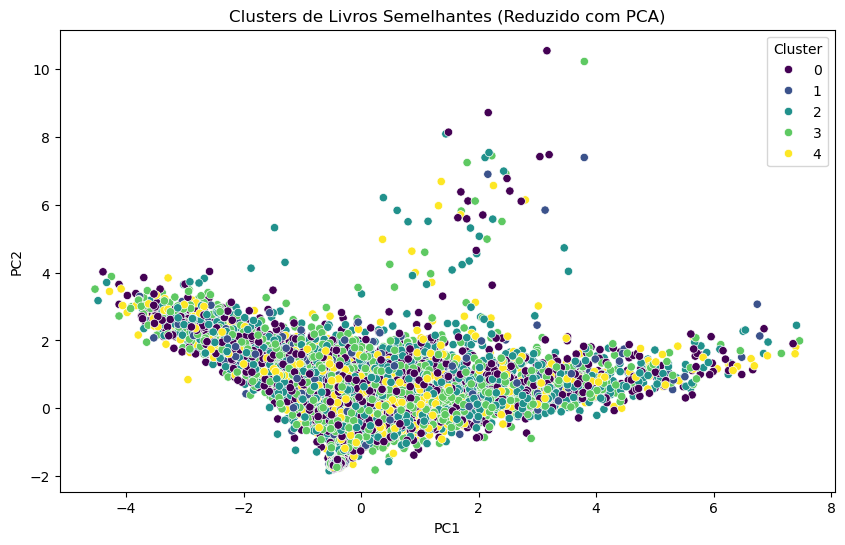

In [88]:
# Visualização 1: Frequência de Tópicos
if 'Dominant_Topic' in books_data_cleaned.columns:
    topic_counts = books_data_cleaned['Dominant_Topic'].value_counts()
    plt.figure(figsize=(10, 6))
    sns.barplot(x=topic_counts.index, y=topic_counts.values, palette="viridis")
    plt.title("Frequência de Tópicos Identificados")
    plt.xlabel("Tópicos")
    plt.ylabel("Número de Livros")
    plt.show()

# Visualização 2: Distribuição de Sentimentos
if 'description_sentiment' in books_data_cleaned.columns:
    plt.figure(figsize=(10, 6))
    sns.histplot(books_data_cleaned['description_sentiment'], kde=True, color='skyblue')
    plt.title("Distribuição de Sentimentos nas Descrições dos Livros")
    plt.xlabel("Sentimento")
    plt.ylabel("Frequência")
    plt.show()

# Visualização 3: Clusters de Livros Semelhantes (PCA)
if 'Cluster' in books_data_cleaned.columns:
    # Reduzindo a dimensionalidade com PCA para visualização
    pca = PCA(n_components=2)
    book_embeddings_2d = pca.fit_transform(book_embeddings)

    # Criando um DataFrame para visualização
    cluster_df = pd.DataFrame(book_embeddings_2d, columns=['PC1', 'PC2'])
    cluster_df['Cluster'] = books_data_cleaned['Cluster']

    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=cluster_df, palette="viridis", legend="full")
    plt.title("Clusters de Livros Semelhantes (Reduzido com PCA)")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.legend(title="Cluster")
    plt.show()